<a href="https://colab.research.google.com/github/unipd-human-data/env-soundnet/blob/main/env-soundnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*The goal of this project is to explore innovative approaches to achieve state-of-the-art performance in environmental sound classification using advanced machine learning techniques.*

# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install pydub librosa

In [4]:
# Loading necessary libraries
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import seaborn
import shutil
import os
import pydub # Library used to handle audio files
import librosa

In [ ]:
esc_50_df = pd.read_csv("/content/drive/MyDrive/HumanData/ESC-50-master/meta/esc50.csv")

def relocate_files(file_name, category, is_esc10):
  src = f"/content/drive/MyDrive/HumanData/ESC-50-master/audio/{file_name}"
  esc50_dest_folder = f"/content/drive/MyDrive/HumanData/ESC-50/{category}"
  esc10_dest_folder = f"/content/drive/MyDrive/HumanData/ESC-10/{category}"

  # Ensure destination folder exists
  os.makedirs(esc50_dest_folder, exist_ok=True)
  if is_esc10:
    os.makedirs(esc10_dest_folder, exist_ok=True)

  dest_esc50 = os.path.join(esc50_dest_folder, file_name)
  dest_esc10 = os.path.join(esc10_dest_folder, file_name)

  # Check if the file already exists in the destination
  if not os.path.exists(dest_esc50):
    shutil.copy(src, dest_esc50)
    print(f"Moved {file_name} to {dest_esc50}")
  else:
    print(f"File '{file_name}' already exists in '{dest_esc50}', skipping...")

  if not os.path.exists(dest_esc10):
    if is_esc10:
      shutil.copy(src, dest_esc10)
      print(f"Moved {file_name} to {dest_esc10}")
  else:
    print(f"File '{file_name}' already exists in '{dest_esc10}', skipping...")


esc_50_df.apply(lambda row: relocate_files(row['filename'], row['category'], row['esc10']), axis = 1)

Moved 1-100032-A-0.wav to /content/drive/MyDrive/HumanData/ESC-50/dog/1-100032-A-0.wav
Moved 1-100032-A-0.wav to /content/drive/MyDrive/HumanData/ESC-10/dog/1-100032-A-0.wav
Moved 1-100038-A-14.wav to /content/drive/MyDrive/HumanData/ESC-50/chirping_birds/1-100038-A-14.wav
Moved 1-100210-A-36.wav to /content/drive/MyDrive/HumanData/ESC-50/vacuum_cleaner/1-100210-A-36.wav
Moved 1-100210-B-36.wav to /content/drive/MyDrive/HumanData/ESC-50/vacuum_cleaner/1-100210-B-36.wav
Moved 1-101296-A-19.wav to /content/drive/MyDrive/HumanData/ESC-50/thunderstorm/1-101296-A-19.wav
Moved 1-101296-B-19.wav to /content/drive/MyDrive/HumanData/ESC-50/thunderstorm/1-101296-B-19.wav
Moved 1-101336-A-30.wav to /content/drive/MyDrive/HumanData/ESC-50/door_wood_knock/1-101336-A-30.wav
Moved 1-101404-A-34.wav to /content/drive/MyDrive/HumanData/ESC-50/can_opening/1-101404-A-34.wav
Moved 1-103298-A-9.wav to /content/drive/MyDrive/HumanData/ESC-50/crow/1-103298-A-9.wav
Moved 1-103995-A-30.wav to /content/drive/My

,0
0,None
1,None
2,None
3,None
4,None
...,...
1995,None
1996,None
1997,None
1998,None


In [ ]:
%ls /content/drive/MyDrive/HumanData/ESC-50/

airplane/        clock_alarm/       door_wood_knock/   insects/          siren/
breathing/       clock_tick/        drinking_sipping/  keyboard_typing/  sneezing/
brushing_teeth/  coughing/          engine/            laughing/         snoring/
can_opening/     cow/               fireworks/         mouse_click/      thunderstorm/
car_horn/        crackling_fire/    footsteps/         pig/              toilet_flush/
cat/             crickets/          frog/              pouring_water/    train/
chainsaw/        crow/              glass_breaking/    rain/             vacuum_cleaner/
chirping_birds/  crying_baby/       hand_saw/          rooster/          washing_machine/
church_bells/    dog/               helicopter/        sea_waves/        water_drops/
clapping/        door_wood_creaks/  hen/               sheep/            wind/


Now we define our main helper class.

In [82]:
class Clip:
  """A single 5-sec long recording."""

  SAMPLING_RATE = 44100 # All recordings in ESC are 44.1 kHz
  FRAME = 512 # Frame size in samples

  class Audio:
    """ The actual audio data of the clip.

        Uses a context manager to load/unload the raw audio data. This way clips
        can be processed sequentially with reasonable memory usage.
    """

    def __init__(self, path) -> None:
      self.path = path

    # returns the resource that needs to be managed
    def __enter__(self):
      # silent AudioSegment  used to trim/overlay frame inacurate clips
      self.data = pydub.AudioSegment.silent(duration=5000)
      self.data = self.data.overlay(pydub.AudioSegment.from_file(self.path)[0:5000])
      self.raw = (np.frombuffer(self.data._data, dtype="int16") + 0.5) / (0x7FFF + 0.5)
      return (self)

   # does not return anything but performs the cleanup operations
    def __exit__(self, exception_type, exception_value, traceback):
      if exception_type is not None:
        print (exception_type)
        print(exception_value)
        print(traceback)
      del self.data
      del self.raw

  def __init__(self, filename) -> None:
    self.filename = os.path.basename(filename)
    self.path = os.path.abspath(filename)
    self.directory = os.path.dirname(self.path)
    self.category = self.directory.split('/')[-1]

    self.audio = Clip.Audio(self.path)
    with self.audio as audio:
      self._compute_mfcc(audio)
      self._compute_zcr(audio)

  def _compute_mfcc(self, audio):
    self.spectogram = librosa.stft(y=self.audio.raw, hop_length=Clip.FRAME)
    self.melspectogram = librosa.feature.melspectrogram(y=self.audio.raw, sr=Clip.SAMPLING_RATE, hop_length=Clip.FRAME)
    self.logamplitude = librosa.amplitude_to_db(self.melspectogram)
    self.mfcc = librosa.feature.mfcc(S=self.logamplitude, n_mfcc=13).transpose()

  def _compute_zcr(self, audio):
    self.zcr = librosa.feature.zero_crossing_rate(self.audio.raw, frame_length=Clip.FRAME, hop_length=Clip.FRAME)

  def __repr__(self):
    return '<{0}/{1}>'.format(self.category, self.filename)

# Exploratory Data Analysis

The ESC dataset is a freely available (Creative Commons Attribution-NonCommercial license) collection of short environmental recordings presented in a unified format (5-second-long clips, 44100 Hz, single channel, Ogg Vorbis compressed @ 192 kbit/s). All clips have been extracted and manually labeled by the author from public field recordings available through the Freesound.org project. Please see the README files for a detailed attribution list.

The dataset consists of three parts:

1. ESC-50: a labeled set of 2 000 environmental recordings (50 classes, 40 clips per class),

2. ESC-10: a labeled set of 400 environmental recordings (10 classes, 40 clips per class) (this is a subset of ESC-50 - created initialy as a proof-of-concept/standardized selection of easy recordings),

3. ESC-US: an unlabeled dataset of 250 000 environmental recordings (5-second-long clips), suitable for unsupervised pre-training.

The ESC-US dataset, although not hand-annotated, includes the labels (tags) submitted by the original uploading users, which could be potentially used in weakly-supervised learning experiments (noisy and/or missing labels). The ESC-10 and ESC-50 datasets have been prearranged into 5 uniformly sized folds, making sure that clips extracted from the same original source recording are always contained in a single fold.

Let us now see and play one random sample's audio clip.

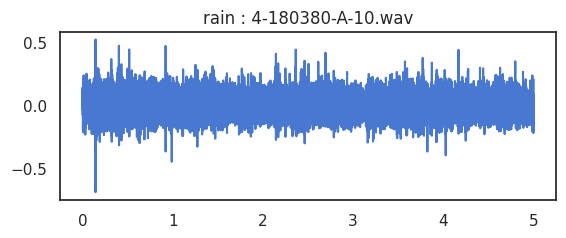

In [81]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sb
sb.set(style="white", palette="muted")

import random
import IPython.display
import glob

wav_files = glob.glob('/content/drive/MyDrive/HumanData/ESC-10/*/*.wav')
clip = Clip(random.choice(wav_files))

with clip.audio as audio:
   plt.subplot(2, 1, 1)
   plt.title('{0} : {1}'.format(clip.category, clip.filename))
   plt.plot(np.arange(0, len(audio.raw)) / 44100.0, audio.raw)

IPython.display.Audio(filename=clip.path, rate=Clip.SAMPLING_RATE)

Next we load all ESC-10 audio files, as Clip class objects, into a list()

In [71]:
def load_dataset(name):
    """Load all dataset recordings into a nested list."""
    clips = []
    for directory in sorted(os.listdir('/content/drive/MyDrive/HumanData/{0}'.format(name))):
        directory = '/content/drive/MyDrive/HumanData/{0}/{1}'.format(name, directory)

        if os.path.isdir(directory):
          print('Parsing ' + directory)
          category = []
          for clip in sorted(os.listdir(directory)):
              if clip[-3:] == 'wav':
                    category.append(Clip('{0}/{1}'.format(directory, clip)))
          clips.append(category)

    IPython.display.clear_output()
    print('All {0} recordings loaded.'.format(name))

    return clips

clips_10 = load_dataset('ESC-10')

All ESC-10 recordings loaded.


We will visualize a single sample from each category to examine the differences in audio waveforms among the various categories.

In [72]:
def add_subplot_axes(ax, position):
    box = ax.get_position()

    position_display = ax.transAxes.transform(position[0:2])
    position_fig = plt.gcf().transFigure.inverted().transform(position_display)
    x = position_fig[0]
    y = position_fig[1]

    return plt.gcf().add_axes([x, y, box.width * position[2], box.height * position[3]], facecolor='w')

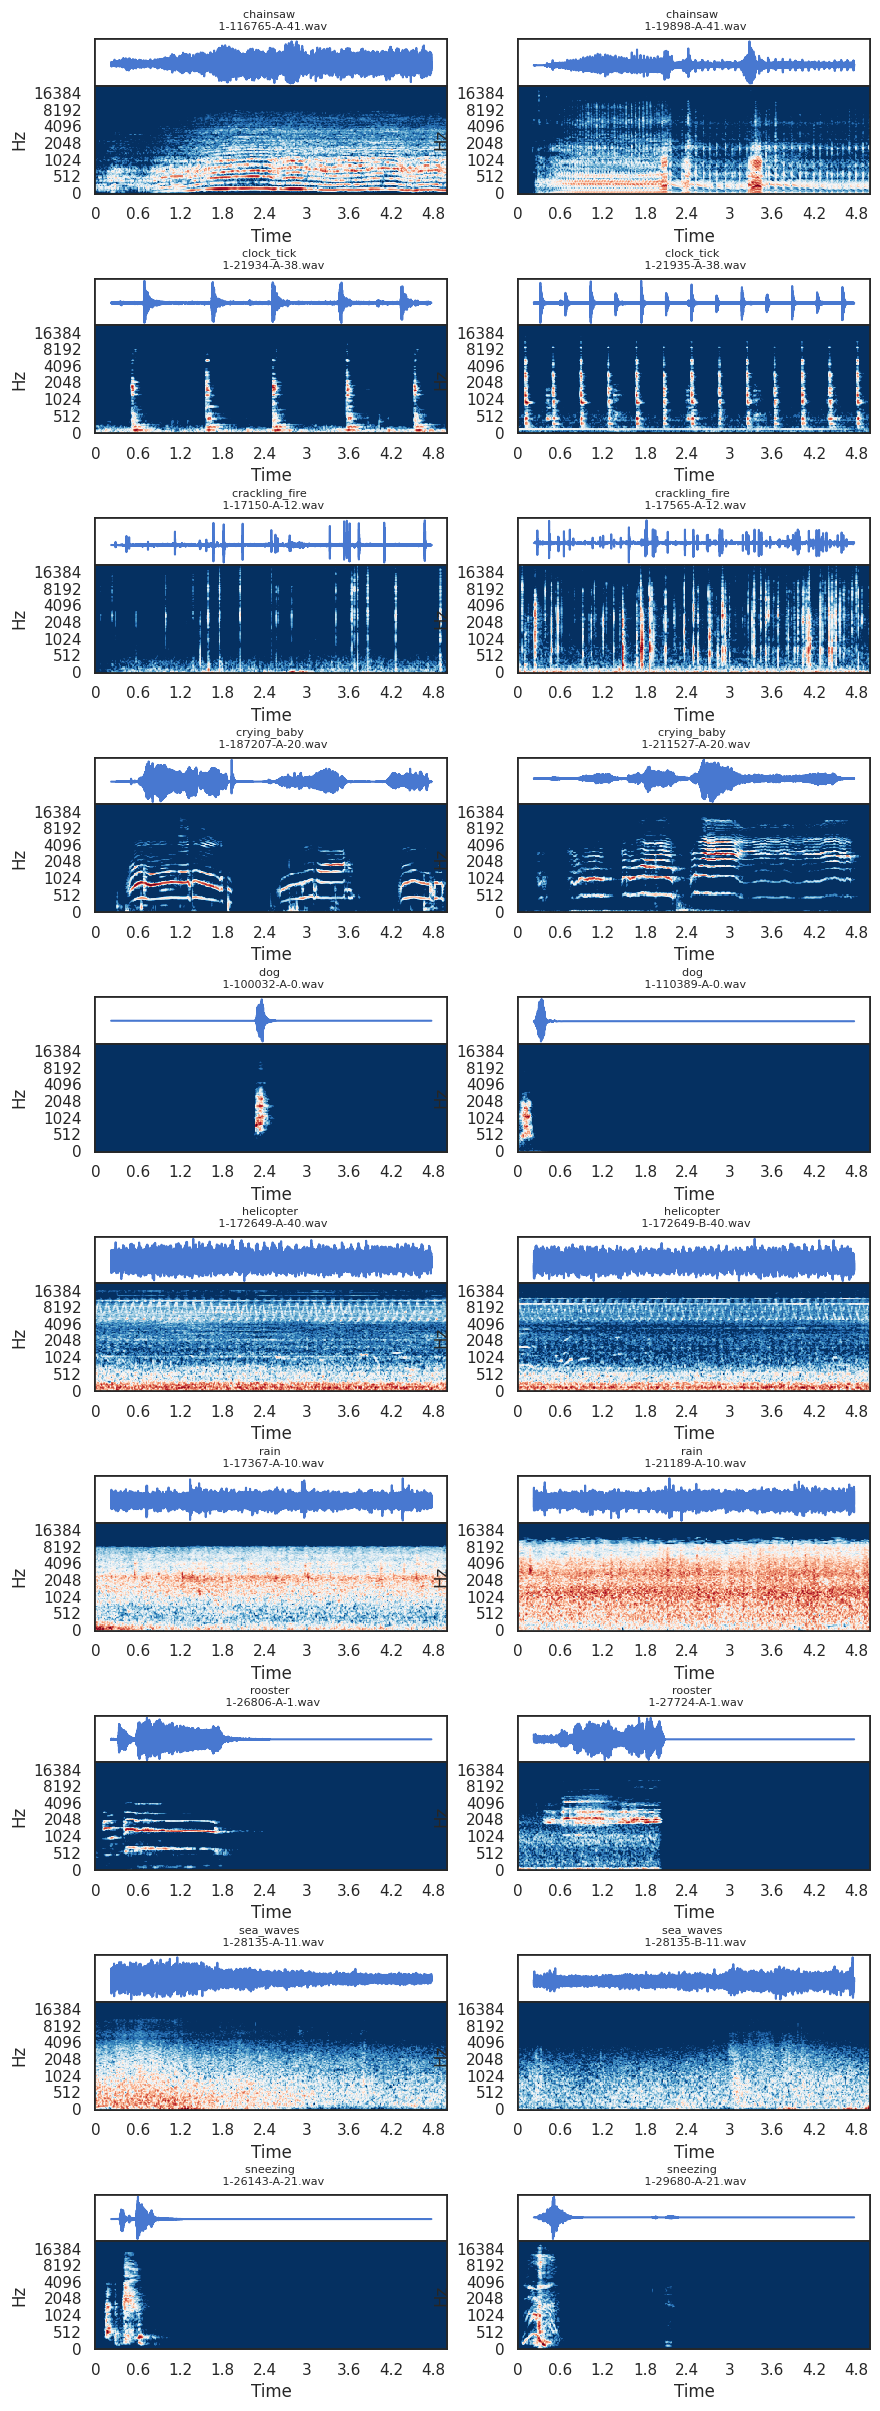

In [84]:
def plot_clip_overview(clip, ax):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax_waveform = add_subplot_axes(ax, [0.0, 0.7, 1.0, 0.3])
    ax_spectrogram = add_subplot_axes(ax, [0.0, 0.0, 1.0, 0.7])

    with clip.audio as audio:
        ax_waveform.plot(np.arange(0, len(audio.raw)) / float(Clip.SAMPLING_RATE), audio.raw)
        ax_waveform.get_xaxis().set_visible(False)
        ax_waveform.get_yaxis().set_visible(False)
        ax_waveform.set_title('{0} \n {1}'.format(clip.category, clip.filename), {'fontsize': 8}, y=1.03)

        librosa.display.specshow(clip.logamplitude, sr=Clip.SAMPLING_RATE, x_axis='time', y_axis='mel', cmap='RdBu_r')
        #ax_spectrogram.get_xaxis().set_visible(False)
        #ax_spectrogram.get_yaxis().set_visible(False)

categories = 10
clips_shown = 2
f, axes = plt.subplots(categories, clips_shown, figsize=(10, 30), sharex=True, sharey=True)
f.subplots_adjust(hspace = 0.55)

for c in range(0, categories):
    for i in range(0, clips_shown):
        plot_clip_overview(clips_10[c][i], axes[c, i])

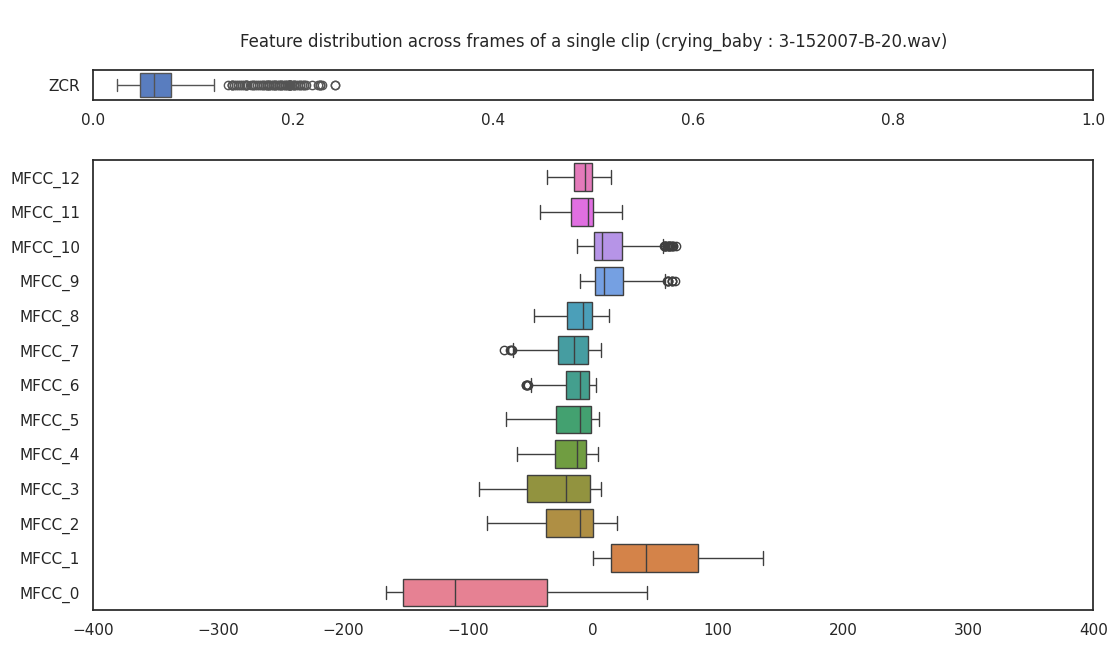

In [99]:
def plot_single_clip(clip):
    col_names = list('MFCC_{}'.format(i) for i in range(np.shape(clip.mfcc)[1]))
    MFCC = pd.DataFrame(clip.mfcc[:, :], columns=col_names)

    f = plt.figure(figsize=(10, 6))
    ax = f.add_axes([0.0, 0.0, 1.0, 1.0])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_frame_on(False)

    ax_mfcc = add_subplot_axes(ax, [0.0, 0.0, 1.0, 0.75])
    ax_mfcc.set_xlim(-400, 400)
    ax_zcr = add_subplot_axes(ax, [0.0, 0.85, 1.0, 0.05])
    ax_zcr.set_xlim(0.0, 1.0)

    plt.title('Feature distribution across frames of a single clip ({0} : {1})'.format(clip.category, clip.filename), y=1.5)

    sb.boxplot(data=MFCC, orient='h', order=list(reversed(MFCC.columns)), ax=ax_mfcc)

    zcr_data = np.array(clip.zcr).transpose().flatten()
    sb.boxplot(data=pd.DataFrame(zcr_data, columns=['ZCR']), orient='h', ax=ax_zcr)

plot_single_clip(clips_10[3][20])

The Zero Crossing Rate is low and tightly packed near 0.1–0.2. This confirms that the clip (crying_baby) has voiced, smoother sounds with few zero crossings, consistent with human vocalizations.


**MFCC_0** often represents the log-energy of the frame. It tends to have the largest variance and magnitude. We will not be paying too much attention to the 0th MFCC, as it's not very interesting (derived from the whole log-spectrum).

**MFCC_1 to MFCC_5**: Tend to have slightly wider IQRs, reflecting core spectral envelope characteristics — think of them as carrying timbral information.

**MFCC_6 to MFCC_12**: Show tighter distributions, meaning they contribute finer details of the spectral shape, often less discriminative on their own.


<ipython-input-126-8220c973ce9e>:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels, fontsize=8)


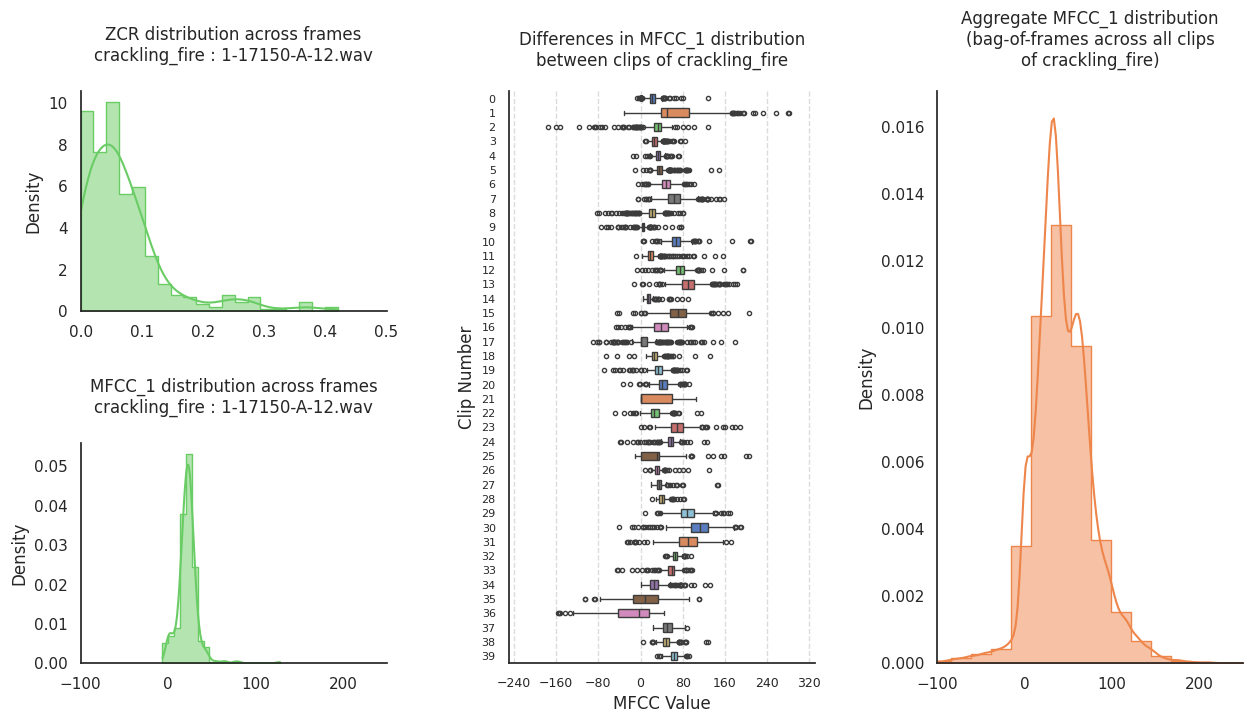

In [126]:
def plot_single_feature_one_clip(feature, title, ax):
    sb.despine()
    ax.set_title(title, y=1.10)
    sb.histplot(feature, bins=20, kde=True, stat="density",
                element="step", fill=True, alpha=0.5,
                color=sb.color_palette("muted", 4)[2], ax=ax)

def plot_single_feature_all_clips(feature, title, ax):
    sb.despine()
    ax.set_title(title, y=1.03)
    bp = sb.boxplot(data=feature, orient='h', width=0.6, fliersize=3,
                   ax=ax, palette="muted")
    labels = [str(i) for i in feature.columns]
    ax.set_yticklabels(labels, fontsize=8)
    ax.set_ylabel("Clip Number")
    ax.xaxis.grid(True, linestyle='--', alpha=0.7)
    ax.set_xlabel("MFCC Value")
    ax.xaxis.set_major_locator(plt.MaxNLocator(8))
    plt.setp(ax.get_xticklabels(), fontsize=9)
    x_min, x_max = ax.get_xlim()
    ax.set_xlim(x_min - (x_max-x_min)*0.1, x_max + (x_max-x_min)*0.05)

def plot_single_feature_aggregate(feature, title, ax):
    sb.despine()
    ax.set_title(title, y=1.03)
    sb.histplot(feature, bins=20, kde=True, stat="density",
                element="step", fill=True, alpha=0.5,
                color=sb.color_palette("muted", 4)[1], ax=ax)

def generate_feature_summary(category, clip, coefficient):
    title = "{0} : {1}".format(clips_10[category][clip].category, clips_10[category][clip].filename)
    MFCC = pd.DataFrame()
    aggregate = np.array([])
    for i in range(0, len(clips_10[category])):

        mfcc_data = clips_10[category][i].mfcc[:, coefficient]
        if isinstance(mfcc_data, np.ndarray) and mfcc_data.ndim > 1:
            mfcc_data = mfcc_data.flatten()

        MFCC[i] = mfcc_data

        if len(aggregate) == 0:
            aggregate = mfcc_data
        else:
            aggregate = np.concatenate([aggregate, mfcc_data])

    # Increase figure size slightly for better spacing
    f = plt.figure(figsize=(15, 12))
    f.subplots_adjust(hspace=0.6, wspace=0.4)  # Increase spacing between plots

    ax1 = plt.subplot2grid((3, 3), (0, 0))
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (0, 1), rowspan=2)
    ax4 = plt.subplot2grid((3, 3), (0, 2), rowspan=2)

    ax1.set_xlim(0.0, 0.5)
    ax2.set_xlim(-100, 250)
    ax4.set_xlim(-100, 250)

    zcr_data = np.array(clips_10[category][clip].zcr)
    if zcr_data.ndim > 1:
        zcr_data = zcr_data.mean(axis=0) if zcr_data.shape[0] > 1 else zcr_data.flatten()

    plot_single_feature_one_clip(zcr_data, 'ZCR distribution across frames\n{0}'.format(title), ax1)
    plot_single_feature_one_clip(clips_10[category][clip].mfcc[:, coefficient], 'MFCC_{0} distribution across frames\n{1}'.format(coefficient, title), ax2)

    plot_single_feature_all_clips(MFCC, 'Differences in MFCC_{0} distribution\nbetween clips of {1}'.format(coefficient, clips_10[category][clip].category), ax3)

    plot_single_feature_aggregate(aggregate, 'Aggregate MFCC_{0} distribution\n(bag-of-frames across all clips\nof {1})'.format(coefficient, clips_10[category][clip].category), ax4)

generate_feature_summary(2, 0, 1)

## Feature extraction



### Zero-Crossing-Rate
And then we visualize two samples waveforms for each category and their relative Zero-Crossing Rate

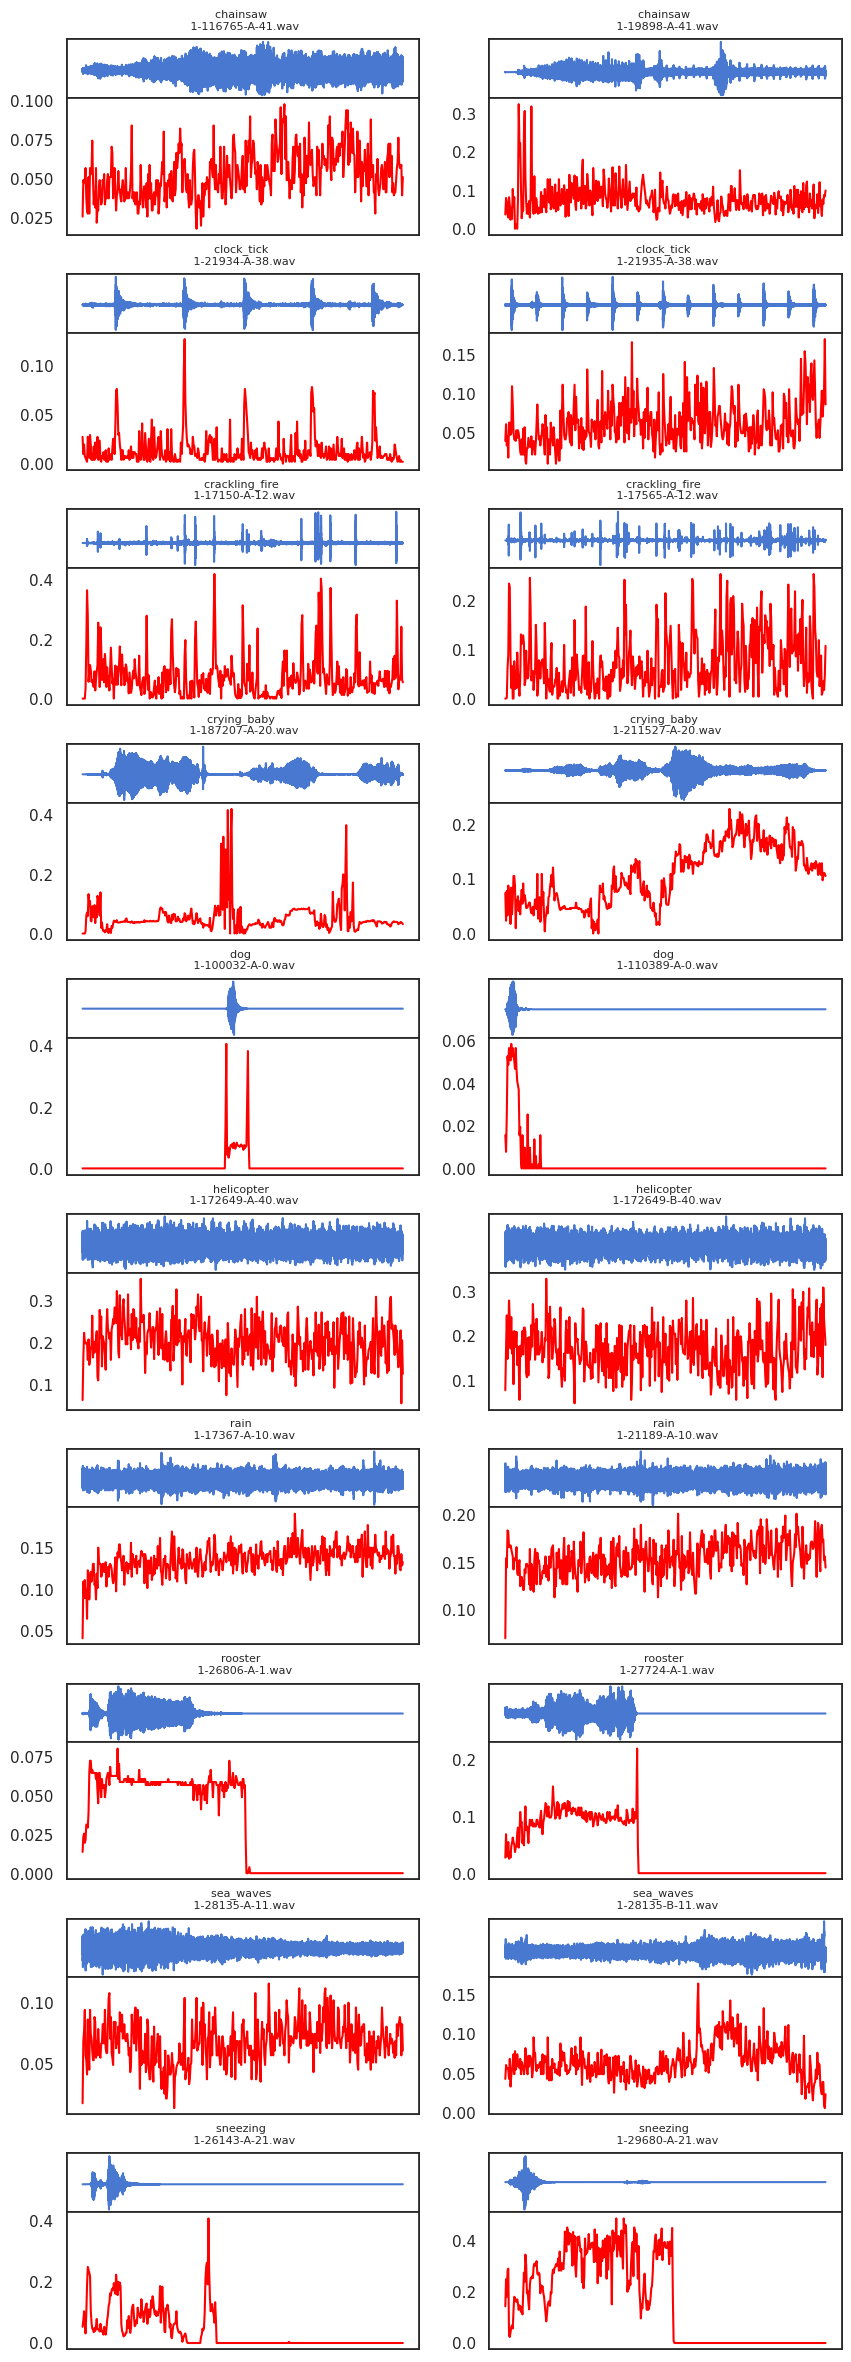

In [80]:
def plot_clip_zcr(clip, ax):
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax_waveform = add_subplot_axes(ax, [0.0, 0.7, 1.0, 0.3])
  ax_zcr = add_subplot_axes(ax, [0.0, 0.0, 1.0, 0.7])

  with clip.audio as audio:
    ax_waveform.plot(np.arange(0, len(audio.raw)) / float(Clip.SAMPLING_RATE), audio.raw)
    ax_waveform.get_xaxis().set_visible(False)
    ax_waveform.get_yaxis().set_visible(False)
    ax_waveform.set_title('{0} \n {1}'.format(clip.category, clip.filename), {'fontsize': 8}, y=1.03)

    clip_zcr = np.array(clip.zcr).transpose()
    ax_zcr.plot(np.arange(0, len(clip_zcr)) / len(clip_zcr) * (len(audio.raw) / 44100.0), clip_zcr, color='red')
    ax_zcr.get_xaxis().set_visible(False)
    #ax_zcr.get_yaxis().set_visible(False)

fig, axes = plt.subplots(categories, clips_shown, figsize=(10, 30), sharex=True, sharey=True)
f.subplots_adjust(hspace = 0.70)

for c in range(0, categories):
    for i in range(0, clips_shown):
        plot_clip_zcr(clips_10[c][i], axes[c, i])

As we can see from this series of plots the ZCR, even if it is a simple feature, it still reflects key temporal and spectral properties of different environmental sounds.

**ZCR Reflects Sound Type**: it gives us insight into the frequency content and "noisiness" of the signal.
For example
- Voiced sounds (like crying baby, dog, rooster, sneezing) tend to have lower and more stable ZCRs. That’s because voiced sounds are periodic with smoother waveforms.

- Noisy or mechanical sounds (like chainsaw, helicopter, crackling fire) often show higher and more erratic ZCRs, due to a higher presence of high-frequency components and randomness.

- Clock ticks show spiky ZCRs, matching the short transient pulses you see in the waveform.

**Signal Onset and ZCR**: ZCR tends to spike at the onset of a sound. For instance:
- In sneezing, the ZCR spikes heavily when the sneeze starts and then falls.

- Similar sharp rises can be seen in dog barks or rooster calls.

**Different Samples, Same Category**: Different samples of the same category show similar patterns between ZCR plots.

**Low-ZCR Examples**: Rain and sea waves show a more continuous waveform and relatively flat ZCR, indicating more stationary, low-frequency sounds


### MelSpec vs FBank vs MFCCs
Mel Spectrograms, Filter Banks (FBank), and MFCCs are **all ways to represent audio** in a form that's more suitable for machine learning or deep learning

---

### 🔊 1. **Mel Spectrogram (MelSpec)**

#### ✅ What it is:
- A **spectrogram** (frequency vs time) where the frequency axis is scaled to the **Mel scale**, which is **non-linear and mimics how humans hear pitch**.
- It shows **how the energy of different frequencies changes over time** — but with Mel-scaled bins.

#### ⚙️ How it's computed:
1. Take the **Short-Time Fourier Transform (STFT)** of the signal.
2. Apply **Mel filter banks** to convert linear frequencies to Mel scale.
3. Optionally take the **log** of the power.

#### 📊 Output:
- 2D matrix: `[n_mels x time_frames]` (like an image!)

---

### 🎛️ 2. **Filter Bank Energies (FBank)**

#### ✅ What it is:
- The **raw output of Mel filter banks** applied to the **power spectrogram**.
- Think of it as a **Mel Spectrogram before taking the log** (or sometimes *after log*, but **before DCT**, which separates it from MFCC).

#### ⚙️ How it's computed:
1. STFT → Power spectrum
2. Apply **Mel filter banks** (same as MelSpec)
3. (Optional) Apply **log**

#### 📊 Output:
- Also a 2D matrix like MelSpec (same shape)
---

### 🎼 3. **MFCC (Mel-Frequency Cepstral Coefficients)**

#### ✅ What it is:
- A **compressed and decorrelated** version of the FBank.
- It represents the **shape of the spectral envelope** (timbre, tone), not the actual raw spectral energy.

#### ⚙️ How it's computed:
1. Start with the **FBank energies** (usually log-scaled).
2. Apply **Discrete Cosine Transform (DCT)** — this helps to **compress** and **reduce redundancy**.
3. Keep only the first **N coefficients** (usually 13–20).

#### 📊 Output:
- A smaller 2D matrix: `[n_mfcc x time_frames]`

---

### 🔁 Summary Table

| Feature    | Info Preserved       | Processing Steps            | Typical Use Case                  | Size      |
|------------|----------------------|------------------------------|-----------------------------------|-----------|
| **MelSpec** | Full frequency + time | STFT → Mel → (log)          | Deep learning, CNNs               | Large     |
| **FBank**   | Filtered freq energy | STFT → Mel → (optional log) | Raw feature for speech/ASR        | Large     |
| **MFCC**    | Envelope shape only  | FBank → DCT                  | Compact input, speech models      | Small     |

---

### 🧠 Intuition
- **MelSpec**: A colorful spectrogram-like heatmap. Very detailed. Great for CNNs.
- **FBank**: Raw mel energy info. A bit less processed.
- **MFCC**: A compact "summary" — like turning the spectrogram into a list of “features” for each moment.

---

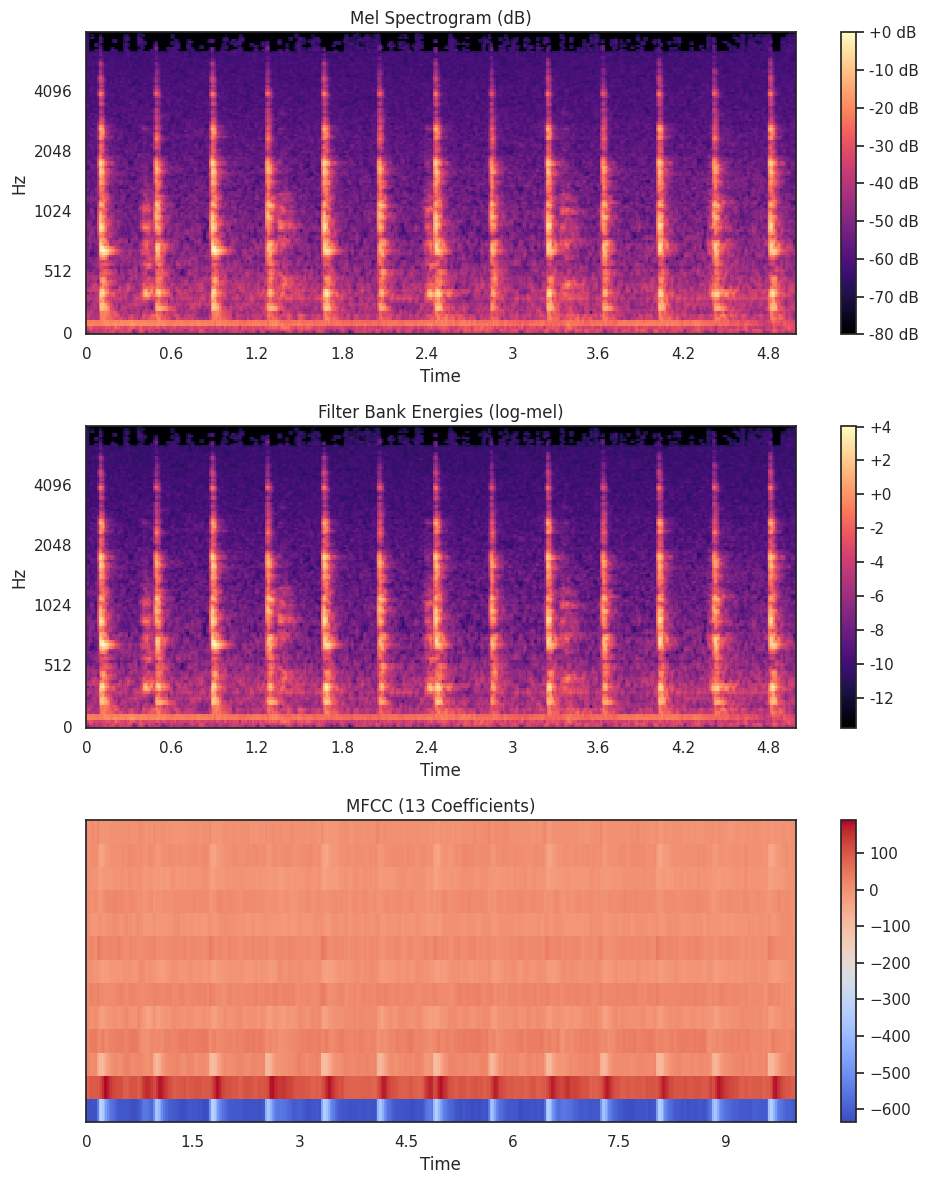

In [16]:

cl = clips_10[1][1]
with cl.audio as audio:
  # Mel Spectrogram
  S_mel = librosa.feature.melspectrogram(y=cl.audio.raw, sr=Clip.SAMPLING_RATE, hop_length=Clip.FRAME)
  S_mel_db = librosa.power_to_db(S_mel, ref=np.max)

  # FBank (log mel energies)
  S_fbank = np.log(S_mel + 1e-6)

  # MFCC
  mfcc = librosa.feature.mfcc(S=S_mel_db, sr=Clip.SAMPLING_RATE, n_mfcc=13)


# Plot
fig, ax = plt.subplots(3, 1, figsize=(10, 12))

img0 = librosa.display.specshow(S_mel_db, x_axis='time', y_axis='mel', sr=Clip.SAMPLING_RATE, fmax=8000, ax=ax[0])
ax[0].set(title='Mel Spectrogram (dB)')
fig.colorbar(img0, ax=ax[0], format='%+2.0f dB')

img1 = librosa.display.specshow(S_fbank, x_axis='time', y_axis='mel', sr=Clip.SAMPLING_RATE, fmax=8000, ax=ax[1])
ax[1].set(title='Filter Bank Energies (log-mel)')
fig.colorbar(img1, ax=ax[1], format='%+2.0f')

img2 = librosa.display.specshow(mfcc, x_axis='time', ax=ax[2])
ax[2].set(title='MFCC (13 Coefficients)')
fig.colorbar(img2, ax=ax[2])

plt.tight_layout()
plt.show()